In [1]:
import os
import sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Modification: Change Matplotlib Backend
# ==============================
# 'notebook' mode often fails in remote/headless environments.
# 'inline' is the most stable option for static plots in Jupyter.
%matplotlib inline 

# Set high-resolution display (Retina optimization for clearer plots)
%config InlineBackend.figure_format = 'retina'

# ==============================
# 1. Setup Environment
# ==============================
# Set working directory to project root
os.chdir("/root/Cycle/Github")
print("Current working directory:", os.getcwd())

# Add custom module path if needed
sys.path.append("./HarmoCycle/")

# ==============================
# 2. Load Data and Process Coordinates
# ==============================
# Load AnnData
print("Loading data...")
adata = sc.read_h5ad('./Dataset/GBMap-Raw.h5ad')
adata1 = sc.read_h5ad('./Dataset/Preprocessed_GBMap/Stem-like_with_CellDensity.h5ad')
adata = adata[adata1.obs_names, :]
adata.obs = adata1.obs.copy()
adata.obsm = adata1.obsm.copy()

# ==============================================================
# Explanation of how `adata` was generated
# ==============================================================
# The raw dataset (GBMap-Raw.h5ad) contains all cells with metadata,
# including a column `annotation_level_2` in `.obs` that specifies cell types.
#
# Step 1: From this raw dataset, only cells annotated as "stem-like" were retained.
# Step 2: On the stem-like subset, a cell density calculation was performed.
#         The resulting density values were stored in `.obs`.
# Step 3: A k-means clustering analysis (k=5) was run on the same subset,
#         and the cluster assignments were also stored in `.obs`.
# Step 4: Both the cell density results and the clustering labels were saved
#         into a new preprocessed AnnData file:
#         `Stem-like_with_CellDensity.h5ad`.
#
# For reproducibility, this preprocessed file is provided directly.
# In the script, we load it as `adata1` and then align the raw dataset (`adata`)
# to the same set of cells by matching `adata1.obs_names`.
# Finally, we overwrite `.obs` and `.obsm` in `adata` with the processed
# annotations and embeddings from `adata1`, ensuring that `adata` now contains
# the necessary information (stem-like cell subset, cell density values,
# and k-means clustering results).

Current working directory: /root/Cycle/Github
Loading data...


In [2]:
import os
import pandas as pd

# 1. Save the original var.index (gene IDs) to a text file (one ID per line)
os.makedirs('./Experiment/Temp_Result', exist_ok=True)
adata.var.index.to_series().to_csv(
    './Experiment/Temp_Result/GBMap_Var_Index.txt',
    index=False,
    header=False
)

# 2. Read the g:Profiler conversion result (mapping gene IDs → gene symbols)
gene_df = pd.read_csv('./Dataset/Preprocessed_GBMap/gProfiler_GBMap.csv')

# 3. Add a new column 'gene_symbol' to adata.var
adata.var['gene_symbol'] = gene_df['name'].values

# 3a. Replace missing or invalid symbols ("None" or starting with "None") with the original IDs
mask_invalid = adata.var['gene_symbol'].isna() | adata.var['gene_symbol'].str.startswith("None")
adata.var.loc[mask_invalid, 'gene_symbol'] = adata.var.index[mask_invalid]

# 3b. Update var_names to use gene_symbol (with fallback to IDs)
adata.var_names = adata.var['gene_symbol']

# 4. Print the number of genes before removing duplicates
print(f"Original number of genes (before make_unique): {adata.var.index.shape[0]}")

# 5. Make var_names unique (remove duplicates by appending suffixes if needed)
adata.var_names_make_unique()

# 6. Print the number of genes after duplicate removal
print(f"Number of genes after make_unique: {adata.var.index.shape[0]}")


Original number of genes (before make_unique): 27983
Number of genes after make_unique: 27983


# Results of K-means Clustering Based on Kernel Density Features

/root/anaconda3/envs/HT2VEC/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 1000x800 with 0 Axes>

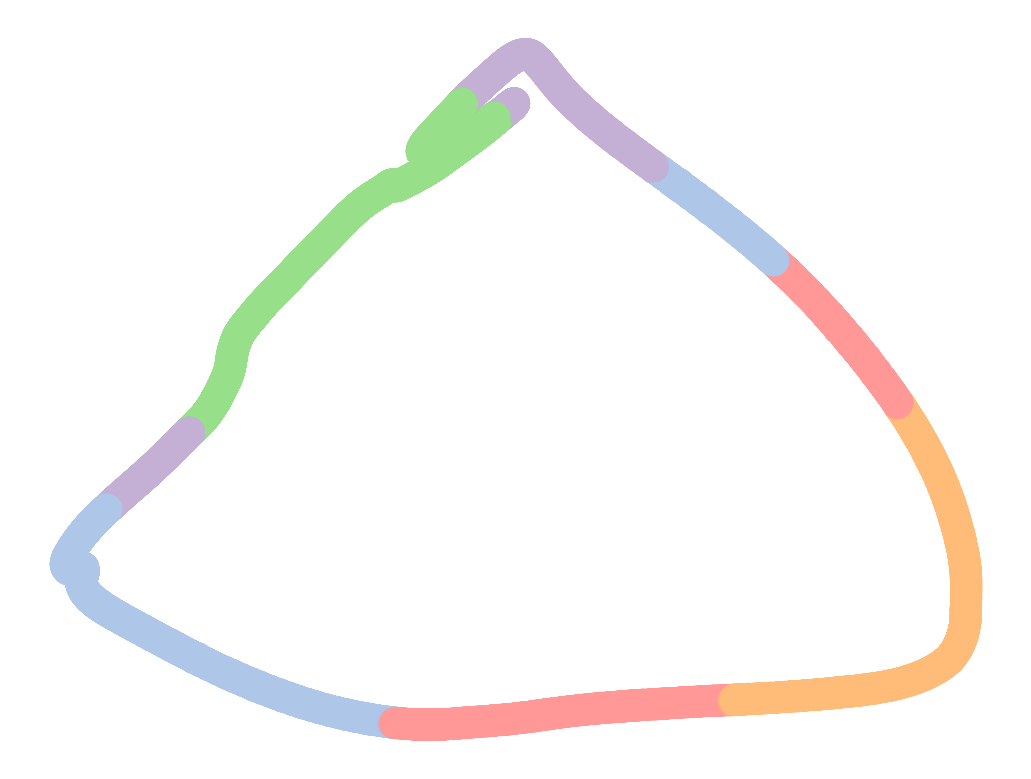

In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import scanpy as sc

# Define Nature-style colors (coolwarm theme adaptation)
# These colors are chosen to provide a balanced palette of cool and warm tones
nature_coolwarm_colors = [
    '#aec7e8',  # Light blue - cool tone
    '#ffbb78',  # Light orange - warm tone
    '#98df8a',  # Light green - cool tone
    '#ff9896',  # Light red - warm tone
    '#c5b0d5',  # Light purple - neutral tone
    '#c49c94',  # Light brown - warm tone
    '#f7b6d2'   # Light pink - warm tone
]

# Set figure size for plotting
plt.figure(figsize=(10, 8))

# Plot UMAP embedding using Scanpy
# - color: cluster assignment (kmeans_cluster)
# - basis: adjusted PCA coordinates (X_pca_adjust)
# - size: point size
# - legend_loc=None: remove legend
# - title='': no title
# - frameon=False: remove frame
# - show=False: prevent immediate display
# - palette: custom Nature-style color palette
sc.pl.embedding(
    adata,
    color='kmeans_cluster',
    basis='X_pca_adjust',
    size=500,
    legend_loc=None,
    title='',
    frameon=False,
    show=False,
    palette=nature_coolwarm_colors
)

# Define output path
output_dir = './FigurePlot/GBMap_Analysis'
output_file = os.path.join(output_dir, 'malignant_kmeans_cluster_X_pca_adjust_plot.png')

# Check if output directory exists; if not, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save figure as PNG
# - dpi=300: high resolution for publication
# - format='png': specify file format
# - bbox_inches='tight': compact layout without extra whitespace
plt.savefig(
    output_file,
    dpi=300,
    format='png',
    bbox_inches='tight'
)

# Display the plot
plt.show()


# Proliferation_score for Clusters

Found 44 out of 44 proliferation genes in dataset
Clusters sorted by proliferation score (high to low): ['2', '4', '0', '3', '1']
Cluster 2 vs Cluster 4: p = 1.68e-59 (Mann-Whitney U)
Cluster 2 vs Cluster 0: p = 0.00e+00 (Mann-Whitney U)
Cluster 2 vs Cluster 3: p = 0.00e+00 (Mann-Whitney U)
Cluster 2 vs Cluster 1: p = 0.00e+00 (Mann-Whitney U)


/root/anaconda3/envs/HT2VEC/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/tmp/ipykernel_39787/3465195303.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


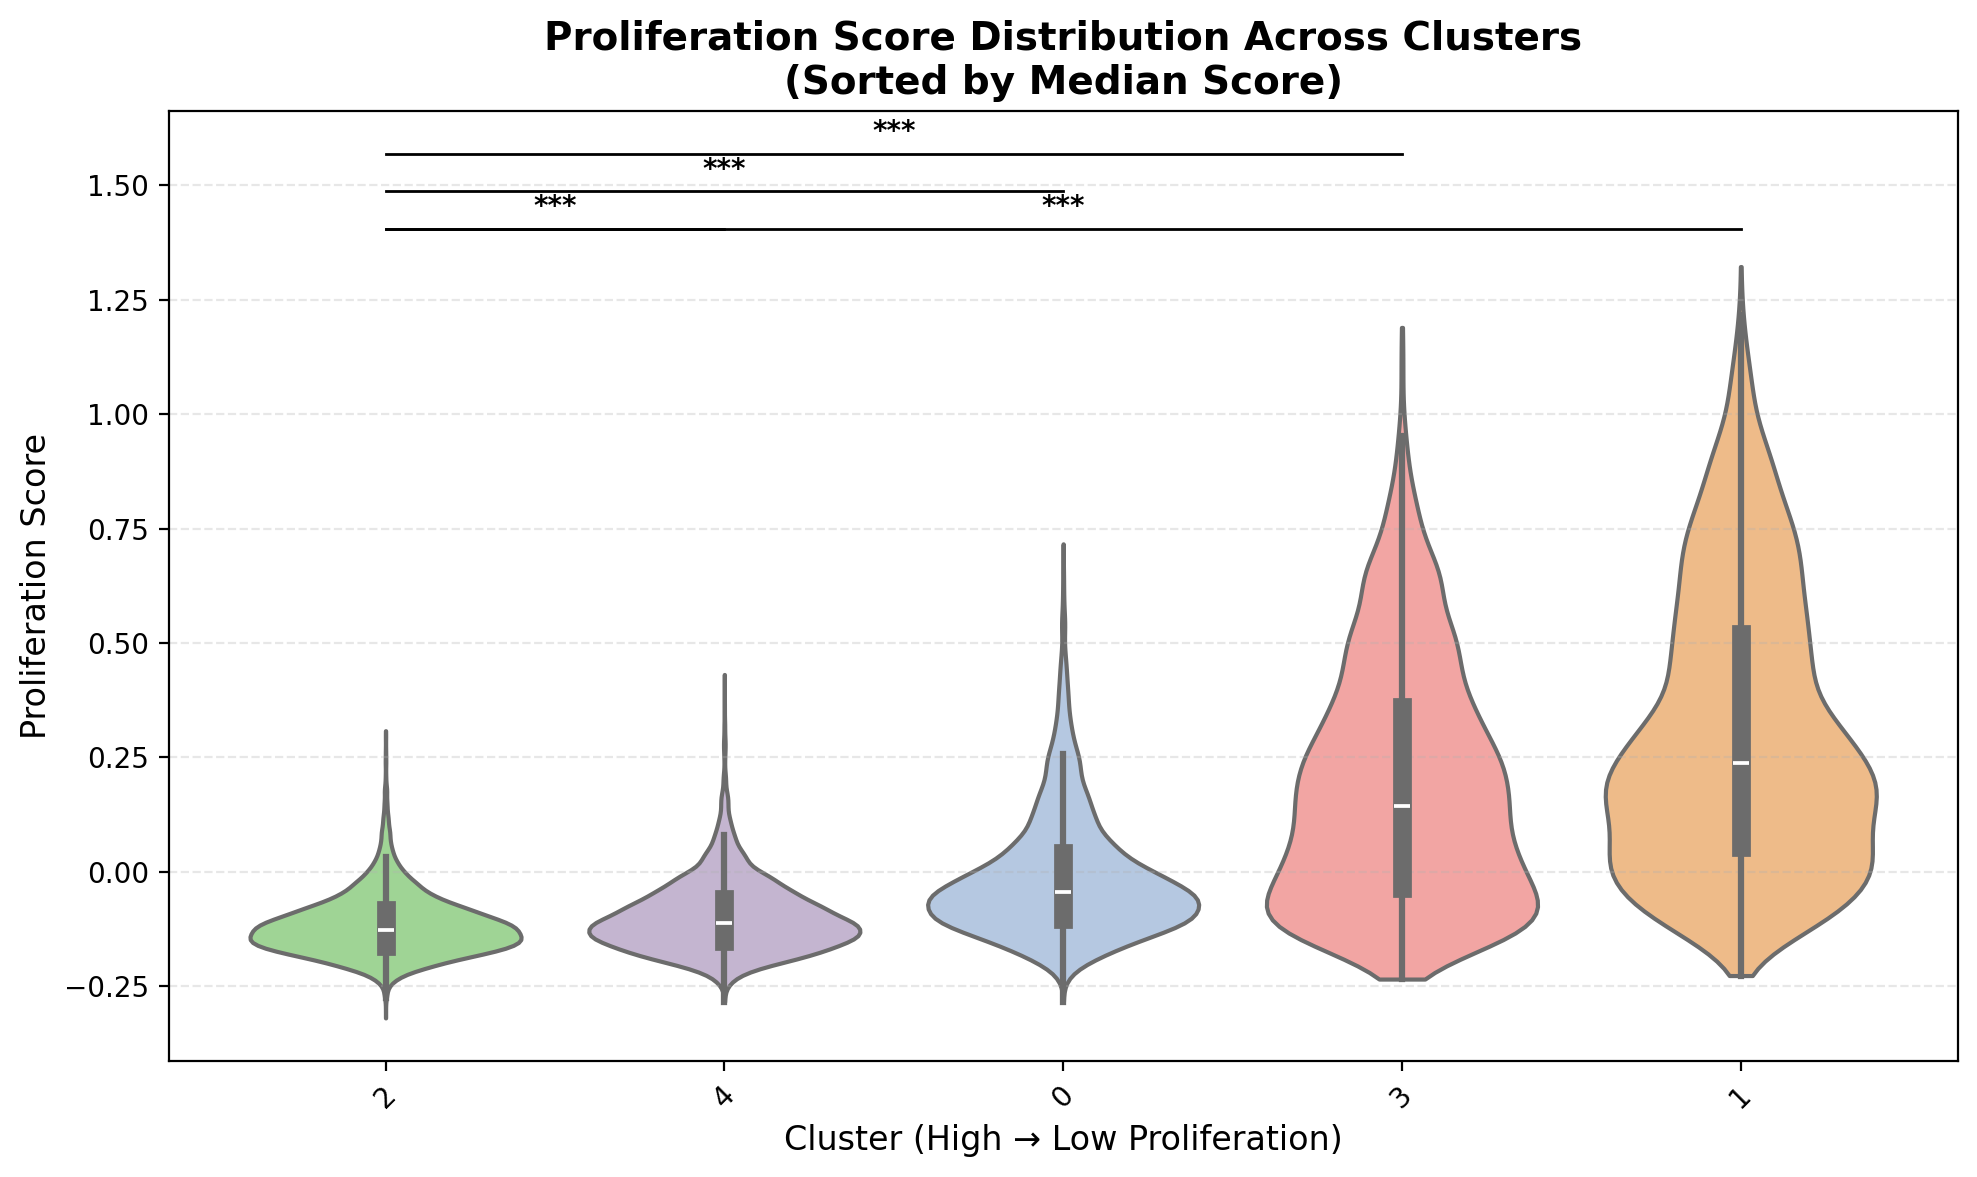

In [4]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

# Custom color palette (Nature-style, coolwarm adaptation)
custom_colors = [
    '#98df8a',  # Light green - cool tone
    '#c5b0d5',  # Light purple - neutral tone
    '#aec7e8',  # Light blue - cool tone
    '#ff9896',  # Light red - warm tone
    '#ffbb78',  # Light orange - warm tone
]

# Ensure fonts in saved PDF/PNG are editable (vectorized text)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Copy AnnData object to avoid modifying the original
temp_adata0 = adata.copy()

# Define proliferation gene set (classic proliferation markers curated for glioma context)
Proliferation_genes_glioma = [
    "ASPM",
    "ATAD2",
    "AURKA",
    "AURKB",
    "BIRC5",
    "CCNB1",
    "CCNB2",
    "CCND1",
    "CCND2",
    "CDC20",
    "CDCA3",
    "CDCA8",
    "CDK1",
    "CDK4",
    "CDK6",
    "CENPA",
    "CENPE",
    "CENPF",
    "CKAP2",
    "CKS2",
    "DLGAP5",
    "ECT2",
    "EGFR",
    "FOXM1",
    "GTSE1",
    "HMMR",
    "KIF2C",
    "KIF4A",
    "MKI67",
    "MYC",
    "NCAPG",
    "NDC80",
    "NEK2",
    "NUSAP1",
    "PCNA",
    "PLK1",
    "PRC1",
    "PTTG1",
    "RRM2",
    "TOP2A",
    "TPX2",
    "TROAP",
    "UBE2C",
    "UHRF1"
]

# Filter genes present in dataset
available_proliferation_genes = [
    gene for gene in Proliferation_genes_glioma if gene in temp_adata0.var_names
]
print(f"Found {len(available_proliferation_genes)} out of {len(Proliferation_genes_glioma)} proliferation genes in dataset")

# Compute proliferation score per cell
sc.tl.score_genes(
    temp_adata0,
    gene_list=available_proliferation_genes,
    score_name='proliferation_score',
    ctrl_size=50,
    use_raw=False)

# Sort clusters by median proliferation score (ascending order)
cluster_proliferation_means = (
    temp_adata0.obs.groupby('kmeans_cluster')['proliferation_score']
    .median()
    .sort_values(ascending=True)
)
sorted_clusters_proliferation = cluster_proliferation_means.index.tolist()
print(f"Clusters sorted by proliferation score (high to low): {sorted_clusters_proliferation}")

# Update cluster order in obs
temp_adata0.obs['kmeans_cluster_proliferation'] = pd.Categorical(
    temp_adata0.obs['kmeans_cluster'],
    categories=sorted_clusters_proliferation,
    ordered=True
)

# Select colors according to number of clusters
n_clusters = len(sorted_clusters_proliferation)
if n_clusters <= len(custom_colors):
    selected_colors = custom_colors[:n_clusters]
else:
    selected_colors = [custom_colors[i % len(custom_colors)] for i in range(n_clusters)]

# Statistical testing: compare reference cluster (highest proliferation) vs others
reference_cluster = sorted_clusters_proliferation[0]
p_values = []

for cluster in sorted_clusters_proliferation[1:]:
    ref_scores = temp_adata0.obs[temp_adata0.obs['kmeans_cluster'] == reference_cluster]['proliferation_score']
    comp_scores = temp_adata0.obs[temp_adata0.obs['kmeans_cluster'] == cluster]['proliferation_score']
    
    # Normality test (Shapiro-Wilk)
    _, ref_normality = stats.shapiro(ref_scores)
    _, comp_normality = stats.shapiro(comp_scores)
    
    if ref_normality > 0.05 and comp_normality > 0.05:
        # Variance homogeneity test
        _, levene_p = stats.levene(ref_scores, comp_scores)
        if levene_p > 0.05:
            # Independent t-test
            t_stat, p_val = stats.ttest_ind(ref_scores, comp_scores, equal_var=True)
            test_used = "t-test"
        else:
            # Welch’s t-test
            t_stat, p_val = stats.ttest_ind(ref_scores, comp_scores, equal_var=False)
            test_used = "Welch's t-test"
    else:
        # Non-parametric Mann-Whitney U test
        u_stat, p_val = stats.mannwhitneyu(ref_scores, comp_scores, alternative='two-sided')
        test_used = "Mann-Whitney U"
    
    p_values.append((cluster, p_val, test_used))
    print(f"Cluster {reference_cluster} vs Cluster {cluster}: p = {p_val:.2e} ({test_used})")

# Plot violin + boxplot (clusters sorted by proliferation score)
plt.figure(figsize=(10, 6))
ax = sns.violinplot(
    data=temp_adata0.obs,
    x='kmeans_cluster_proliferation',
    y='proliferation_score',
    inner='box',
    palette=selected_colors,
    cut=0,
    linewidth=1.5,
    order=sorted_clusters_proliferation
)
plt.title(
    'Proliferation Score Distribution Across Clusters\n(Sorted by Median Score)',
    fontsize=14,
    fontweight='bold'
)
plt.ylabel('Proliferation Score', fontsize=12)
plt.xlabel('Cluster (High → Low Proliferation)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add p-value annotations
y_max = temp_adata0.obs['proliferation_score'].max()
y_step = (y_max - temp_adata0.obs['proliferation_score'].min()) * 0.05

for i, (cluster, p_val, test_used) in enumerate(p_values):
    x_pos = i + 1  # start from second cluster
    y_pos = y_max + y_step * (i % 3 + 1)  # stagger positions
    
    if p_val < 0.001:
        significance = '***'
    elif p_val < 0.01:
        significance = '**'
    elif p_val < 0.05:
        significance = '*'
    else:
        significance = 'ns'
    
    plt.plot([0, x_pos], [y_pos, y_pos], 'k-', lw=1)
    plt.text(x_pos/2, y_pos + y_step*0.2, significance,
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()

# Save figure as PNG, ensuring directory exists
output_dir = './FigurePlot/GBMap_Analysis'
output_file = os.path.join(output_dir, 'proliferation_score_violin_sorted.png')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

plt.savefig(output_file, dpi=300, bbox_inches='tight', format='png')
plt.show()


# Quiescence_score for Clusters

Found 49 out of 49 quiescence genes in dataset
Clusters sorted by quiescence score (high to low): ['2', '1', '3', '4', '0']
Cluster 2 vs Cluster 1: p = 6.23e-17 (Mann-Whitney U)
Cluster 2 vs Cluster 3: p = 8.44e-52 (Mann-Whitney U)
Cluster 2 vs Cluster 4: p = 3.03e-48 (Mann-Whitney U)


/root/anaconda3/envs/HT2VEC/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Cluster 2 vs Cluster 0: p = 2.10e-214 (Mann-Whitney U)


/tmp/ipykernel_39787/2013352674.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


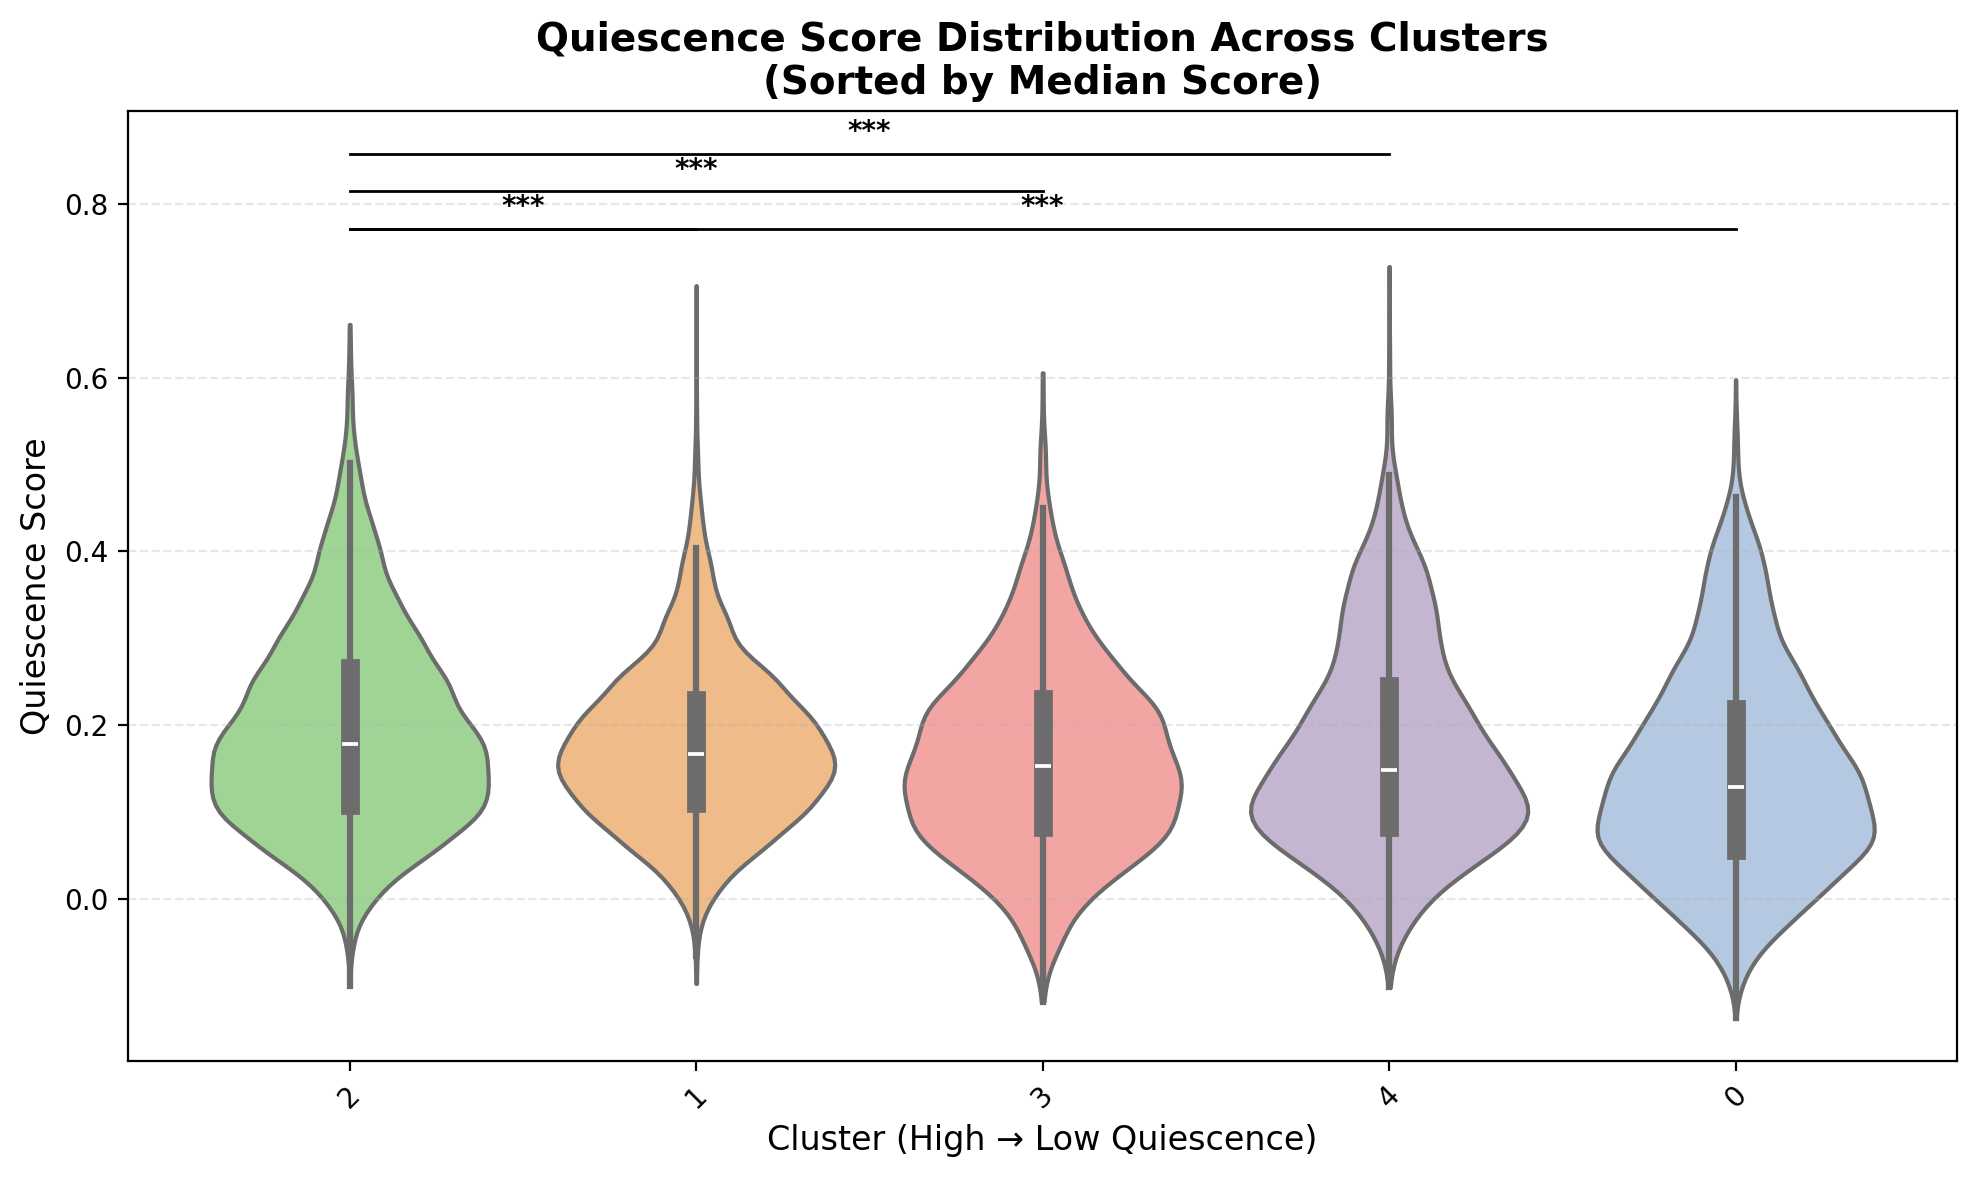


Statistical test summary:
Reference cluster: 2 (highest quiescence score)
vs Cluster 1: Mann-Whitney U, p = 6.23e-17
vs Cluster 3: Mann-Whitney U, p = 8.44e-52
vs Cluster 4: Mann-Whitney U, p = 3.03e-48
vs Cluster 0: Mann-Whitney U, p = 2.10e-214


In [5]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

# Define output directory and file name
output_dir = './FigurePlot/GBMap_Analysis'
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'quiescence_score_violin_sorted.png')

# Custom color palette
custom_colors = [
    '#98df8a',  # light green - cool tone
    '#ffbb78',  # light orange - warm tone
    '#ff9896',  # light red - warm tone
    '#c5b0d5',  # light purple - neutral
    '#aec7e8',  # light blue - cool tone
]

# Ensure fonts are editable in PDF/Vector outputs
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Copy AnnData object
temp_adata0 = adata.copy()

# Define quiescence gene set
Quiescence_genes = [
    'PROM1','CD44','VIM','SOX4','SOX9','SOX6','NES','GFAP','ID1','ID2','ID3','ID4',
    'KLF4','KLF6','KLF9','HES1','HES2','HEY2','HIF3A','EPAS1','TGFB1','TGFB2','TGFBR2','TGFBR3',
    'PDPN','LGALS1','LGALS3','THY1','SPARC','TNC','VCAN','FN1','BCAN','CHI3L1','CHI3L2',
    'SERPINE1','SERPINI1','MDK','HMOX1','NDRG1','SFRP4','DKK1','LIF','LIFR','SOX8',
    'CDKN1A','CDKN1C','BTG1','BTG2'
]

# Filter genes present in dataset
available_quiescence_genes = [gene for gene in Quiescence_genes if gene in temp_adata0.var_names]
print(f"Found {len(available_quiescence_genes)} out of {len(Quiescence_genes)} quiescence genes in dataset")

# Compute quiescence score
sc.tl.score_genes(temp_adata0, gene_list=available_quiescence_genes, score_name='quiescence_score', ctrl_size=50, use_raw=False)

# Sort clusters by median quiescence score (descending order)
cluster_quiescence_means = (
    temp_adata0.obs.groupby('kmeans_cluster')['quiescence_score']
    .median()
    .sort_values(ascending=False)
)
sorted_clusters_quiescence = cluster_quiescence_means.index.tolist()
print(f"Clusters sorted by quiescence score (high to low): {sorted_clusters_quiescence}")

# Update cluster order in obs
temp_adata0.obs['kmeans_cluster_quiescence'] = pd.Categorical(
    temp_adata0.obs['kmeans_cluster'],
    categories=sorted_clusters_quiescence,
    ordered=True
)

# Select colors based on number of clusters
n_clusters = len(sorted_clusters_quiescence)
if n_clusters <= len(custom_colors):
    selected_colors = custom_colors[:n_clusters]
else:
    selected_colors = [custom_colors[i % len(custom_colors)] for i in range(n_clusters)]

# Statistical tests: compare reference cluster (highest quiescence) with others
reference_cluster = sorted_clusters_quiescence[0]
p_values = []

for cluster in sorted_clusters_quiescence[1:]:
    ref_scores = temp_adata0.obs[temp_adata0.obs['kmeans_cluster'] == reference_cluster]['quiescence_score']
    comp_scores = temp_adata0.obs[temp_adata0.obs['kmeans_cluster'] == cluster]['quiescence_score']
    
    # Normality test (Shapiro-Wilk)
    _, ref_normality = stats.shapiro(ref_scores)
    _, comp_normality = stats.shapiro(comp_scores)
    
    if ref_normality > 0.05 and comp_normality > 0.05:
        # Variance homogeneity test
        _, levene_p = stats.levene(ref_scores, comp_scores)
        if levene_p > 0.05:
            t_stat, p_val = stats.ttest_ind(ref_scores, comp_scores, equal_var=True)
            test_used = "t-test"
        else:
            t_stat, p_val = stats.ttest_ind(ref_scores, comp_scores, equal_var=False)
            test_used = "Welch's t-test"
    else:
        u_stat, p_val = stats.mannwhitneyu(ref_scores, comp_scores, alternative='two-sided')
        test_used = "Mann-Whitney U"
    
    p_values.append((cluster, p_val, test_used))
    print(f"Cluster {reference_cluster} vs Cluster {cluster}: p = {p_val:.2e} ({test_used})")

# Plot violin + boxplot
plt.figure(figsize=(10, 6))
ax = sns.violinplot(
    data=temp_adata0.obs,
    x='kmeans_cluster_quiescence',
    y='quiescence_score',
    inner='box',
    palette=selected_colors,
    cut=0,
    linewidth=1.5,
    order=sorted_clusters_quiescence
)
plt.title('Quiescence Score Distribution Across Clusters\n(Sorted by Median Score)', fontsize=14, fontweight='bold')
plt.ylabel('Quiescence Score', fontsize=12)
plt.xlabel('Cluster (High → Low Quiescence)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add p-value annotations
y_max = temp_adata0.obs['quiescence_score'].max()
y_step = (y_max - temp_adata0.obs['quiescence_score'].min()) * 0.05

for i, (cluster, p_val, test_used) in enumerate(p_values):
    x_pos = i + 1
    y_pos = y_max + y_step * (i % 3 + 1)
    
    if p_val < 0.001:
        significance = '***'
    elif p_val < 0.01:
        significance = '**'
    elif p_val < 0.05:
        significance = '*'
    else:
        significance = 'ns'
    
    plt.plot([0, x_pos], [y_pos, y_pos], 'k-', lw=1)
    plt.text(x_pos/2, y_pos + y_step*0.2, significance,
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
# Save figure to specified path
plt.savefig(output_file, dpi=300, bbox_inches='tight', format='png')
plt.show()

# Print summary of statistical tests
print(f"\nStatistical test summary:")
print(f"Reference cluster: {reference_cluster} (highest quiescence score)")
for cluster, p_val, test_used in p_values:
    print(f"vs Cluster {cluster}: {test_used}, p = {p_val:.2e}")


# DEG Analysis between Target vs Others

In [6]:
adata_sub = adata.copy()

# Step 1: Inspect the original cluster values
print("Original values of kmeans_cluster:", adata_sub.obs['kmeans_cluster'].unique())
print("Data type of kmeans_cluster:", type(adata_sub.obs['kmeans_cluster'].iloc[0]))

# Step 2: Convert kmeans_cluster to categorical type for proper handling
adata_sub.obs['kmeans_cluster'] = adata_sub.obs['kmeans_cluster'].astype(str).astype('category')
print("Converted data type:", adata_sub.obs['kmeans_cluster'].dtype)
print("Cluster categories:", adata_sub.obs['kmeans_cluster'].cat.categories.tolist())

# Step 3: Calculate the median cell_density for each cluster
cluster_median_density = adata_sub.obs.groupby('kmeans_cluster')['cell_density'].median()
print(cluster_median_density)

# Import required libraries
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Step 4: Set Scanpy verbosity and print header information
sc.settings.verbosity = 3
sc.logging.print_header()

# Step 5: Define comparison groups for differential gene expression analysis
# - Cells in cluster '2' are labeled as 'target'
# - All other cells are labeled as 'reference'
adata_sub.obs['comparison_group'] = 'other'
adata_sub.obs.loc[~adata_sub.obs['kmeans_cluster'].isin(['2']), 'comparison_group'] = 'reference'
adata_sub.obs.loc[adata_sub.obs['kmeans_cluster'].isin(['2']), 'comparison_group'] = 'target'
adata_sub.obs['comparison_group'] = adata_sub.obs['comparison_group'].astype('category')

print("Distribution of new comparison groups:")
print(adata_sub.obs['comparison_group'].value_counts())

# Step 6: Perform differential gene expression analysis
sc.tl.rank_genes_groups(
    adata_sub, 
    groupby='comparison_group',
    groups=['target'],
    reference='reference',
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    use_raw=False
)

print("Differential gene expression analysis completed!")

# Step 7: Extract results into a DataFrame
result = sc.get.rank_genes_groups_df(adata_sub, group='target')

# Step 8: Identify significantly upregulated genes
upregulated_genes = result[
    (result['pvals_adj'] < 1e-10) & 
    (result['logfoldchanges'] > 1)
].sort_values('logfoldchanges', ascending=False)

# Step 9: Identify significantly downregulated genes
downregulated_genes = result[
    (result['pvals_adj'] < 1e-10) & 
    (result['logfoldchanges'] < -1)
].sort_values('logfoldchanges', ascending=False)

print(f"\nFound {len(upregulated_genes)} significantly upregulated genes")
print(f"\nFound {len(downregulated_genes)} significantly downregulated genes")


Original values of kmeans_cluster: ['2', '4', '0', '3', '1']
Categories (5, object): ['0', '1', '2', '3', '4']
Data type of kmeans_cluster: <class 'str'>
Converted data type: category
Cluster categories: ['0', '1', '2', '3', '4']
kmeans_cluster
0    0.002452
1    0.001492
2    0.003324
3    0.002019
4    0.002896
Name: cell_density, dtype: float64
scanpy==1.9.8 anndata==0.9.2 umap==0.5.6 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13
Distribution of new comparison groups:
reference    25765
target       13084
Name: comparison_group, dtype: int64
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by

In [7]:
upregulated_genes.to_csv('./Experiment/Temp_Result/cluster2_vs_others_upregulated_genes.csv', index=False)
downregulated_genes.to_csv('./Experiment/Temp_Result/cluster2_vs_others_downregulated_genes.csv', index=False)

# Gene Volcano Plot

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


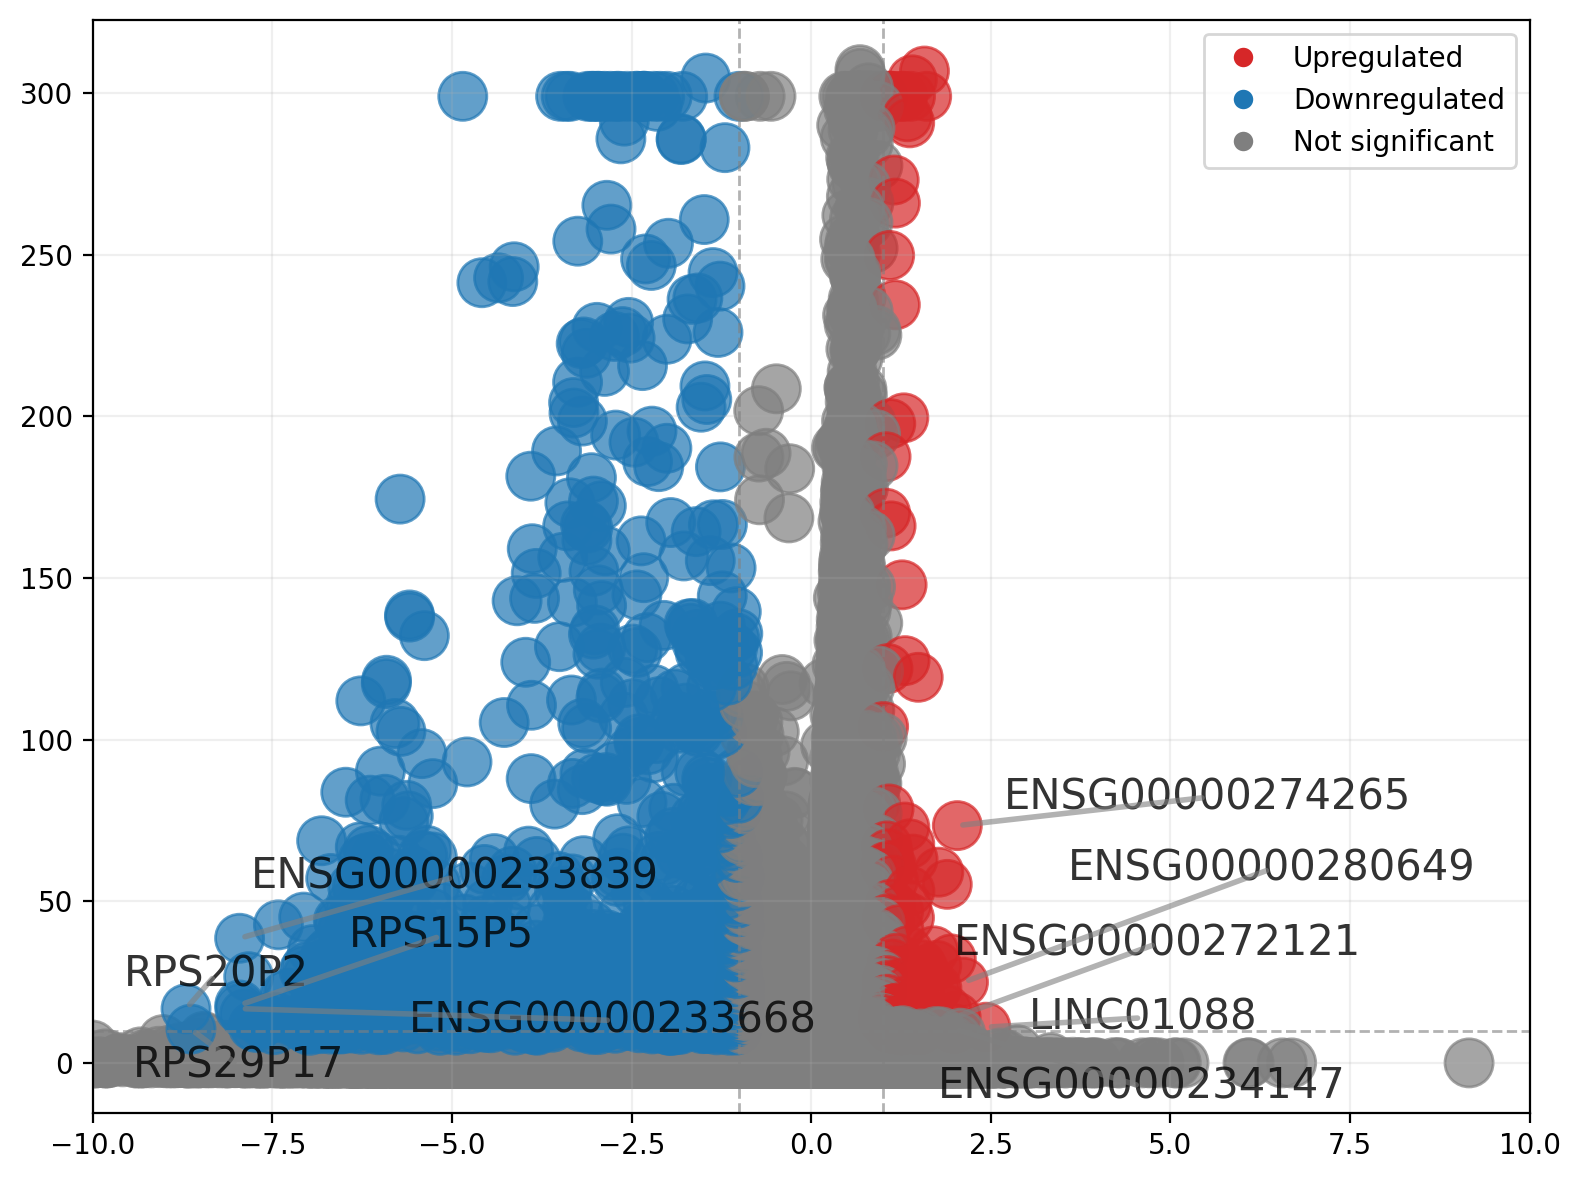

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text
from matplotlib.lines import Line2D

# Replace zero p-values with a very small number to avoid -log10(0) errors
result.loc[result['pvals_adj'] == 0, 'pvals_adj'] = 1e-299
result.loc[result['pvals'] == 0, 'pvals'] = 1e-299
upregulated_genes.loc[upregulated_genes['pvals_adj'] == 0, 'pvals_adj'] = 1e-299
upregulated_genes.loc[upregulated_genes['pvals'] == 0, 'pvals'] = 1e-299
downregulated_genes.loc[downregulated_genes['pvals'] == 0, 'pvals'] = 1e-299
downregulated_genes.loc[downregulated_genes['pvals_adj'] == 0, 'pvals_adj'] = 1e-299

# Custom color palette
custom_colors = [
    '#ffbb78',  # light orange
    '#d62728',  # red (warm tone) - upregulated
    '#1f77b4',  # deep blue (cool tone) - downregulated
    '#c5b0d5',  # light purple
    '#7f7f7f',  # gray (neutral) - not significant
]

# Volcano plot
plt.figure(figsize=(8, 6))

log2fc = result['logfoldchanges']
log10_pval = -np.log10(result['pvals_adj'])

# Thresholds
sig_threshold = 1e-10
fc_threshold = 1

# Assign colors based on thresholds
colors = []
for i in range(len(result)):
    pval = result['pvals_adj'].iloc[i]
    fc = result['logfoldchanges'].iloc[i]
    if pval < sig_threshold and fc > fc_threshold:
        colors.append(custom_colors[1])  # upregulated
    elif pval < sig_threshold and fc < -fc_threshold:
        colors.append(custom_colors[2])  # downregulated
    else:
        colors.append(custom_colors[4])  # not significant

# Scatter plot
plt.scatter(log2fc, log10_pval, c=colors, alpha=0.7, s=300)
plt.xlim(-10, 10)

# Threshold lines
plt.axhline(-np.log10(sig_threshold), color='grey', linestyle='--', alpha=0.6, linewidth=1)
plt.axvline(x=fc_threshold, color='grey', linestyle='--', alpha=0.6, linewidth=1)
plt.axvline(x=-fc_threshold, color='grey', linestyle='--', alpha=0.6, linewidth=1)

# Label top genes (5 upregulated + 5 downregulated)
top_up_genes = upregulated_genes.head(5)
top_down_genes = downregulated_genes.tail(5)
top_genes = pd.concat([top_up_genes, top_down_genes])

texts = []
for _, row in top_genes.iterrows():
    texts.append(plt.text(
        row['logfoldchanges'],
        -np.log10(row['pvals_adj']),
        row['names'],
        fontsize=15,
        alpha=0.8
    ))

# Adjust text positions to avoid overlap
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', color='gray', alpha=0.6, lw=2),
    expand_points=(1.2, 1.2),
    expand_text=(1.2, 1.2),
    force_text=(0.5, 0.5)
)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_colors[1], markersize=8, label='Upregulated'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_colors[2], markersize=8, label='Downregulated'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_colors[4], markersize=8, label='Not significant')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True, alpha=0.2)
plt.tight_layout()

# --- Save figures ---
# Ensure output directories exist
png_dir = './FigurePlot/GBMap_Analysis'
os.makedirs(png_dir, exist_ok=True)

# Save as PNG for quick viewing
plt.savefig(os.path.join(png_dir, 'GBMap_cluster2_vs_others_DEG_volcano_plot.png'), dpi=300, bbox_inches='tight')

plt.show()


---

**We will proceed with GO analysis. In our manuscript, GO enrichment was conducted using g:Profiler because mitochondrial genes were involved. Specifically, all 110 upregulated genes were submitted to g:GOSt, with the results provided in *./Dataset/Preprocessed_GBMap/gProfiler_Up_gene_GBMap.csv*. Likewise, 906 downregulated genes were analyzed, and the corresponding results are available in *./Dataset/Preprocessed_GBMap/gProfiler_Down_gene_GBMap.csv*.**

---

In [9]:
import pandas as pd

# Read the CSV file containing downregulated genes
df = pd.read_csv("./Experiment/Temp_Result/cluster2_vs_others_downregulated_genes.csv")

# Extract only the 'names' column
names = df["names"]

# Save the extracted names to a text file, one gene name per line
output_path = "./Experiment/Temp_Result/cluster2_vs_others_downregulated_gene_names_only.txt"
names.to_csv(output_path, index=False, header=False)

import pandas as pd

# Read the CSV file containing upregulated genes
df = pd.read_csv("./Experiment/Temp_Result/cluster2_vs_others_upregulated_genes.csv")

# Extract only the 'names' column
names = df["names"]

# Save the extracted names to a text file, one gene name per line
output_path = "./Experiment/Temp_Result/cluster2_vs_others_upregulated_gene_names_only.txt"
names.to_csv(output_path, index=False, header=False)


# Up gene GO

Current working directory: /root/Cycle/Github


                Enrichment Analysis Results

--- GO Biological Process (Top 10) ---
No significant enrichment results found for 'GO_Biological_Process_2021'.

--- GO Molecular Function (Top 10) ---
No significant enrichment results found for 'GO_Molecular_Function_2021'.

--- GO Cellular Component (Top 10) ---
No significant enrichment results found for 'GO_Cellular_Component_2021'.
--- Data Prepared for Plotting ---
                                                 Term  -log10(AdjP)  Overlap
22                      Stress response to copper ion      3.711990     4/14
21                       Detoxification of copper ion      3.711990     4/14
20                               Response to chemical      3.913800  33/3909
19  Mitochondrial atp synthesis coupled electron\n...      4.144548     7/99
18           Atp synthesis coupled electron transport      4.144548     7/99
17                   Aerobic electron transport chain      4.399925  

/root/Cycle/Github/./HarmoCycle/Utils.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Term'] = plot_data['Term'].str.replace(r'\s\(GO:\d+\)$', '', regex=True)
/root/Cycle/Github/./HarmoCycle/Utils.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Term'] = plot_data['Term'].apply(


Plot saved to: ./FigurePlot/GBMap_Analysis/GBMap_cluster2_upregulated_GO_BP_enrichment.png
Tip: For Adobe Illustrator editing, save as .pdf or .svg format.


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Top Enriched GO Biological Processes'}, xlabel='-log$_{10}$(Adjusted P-value)'>)

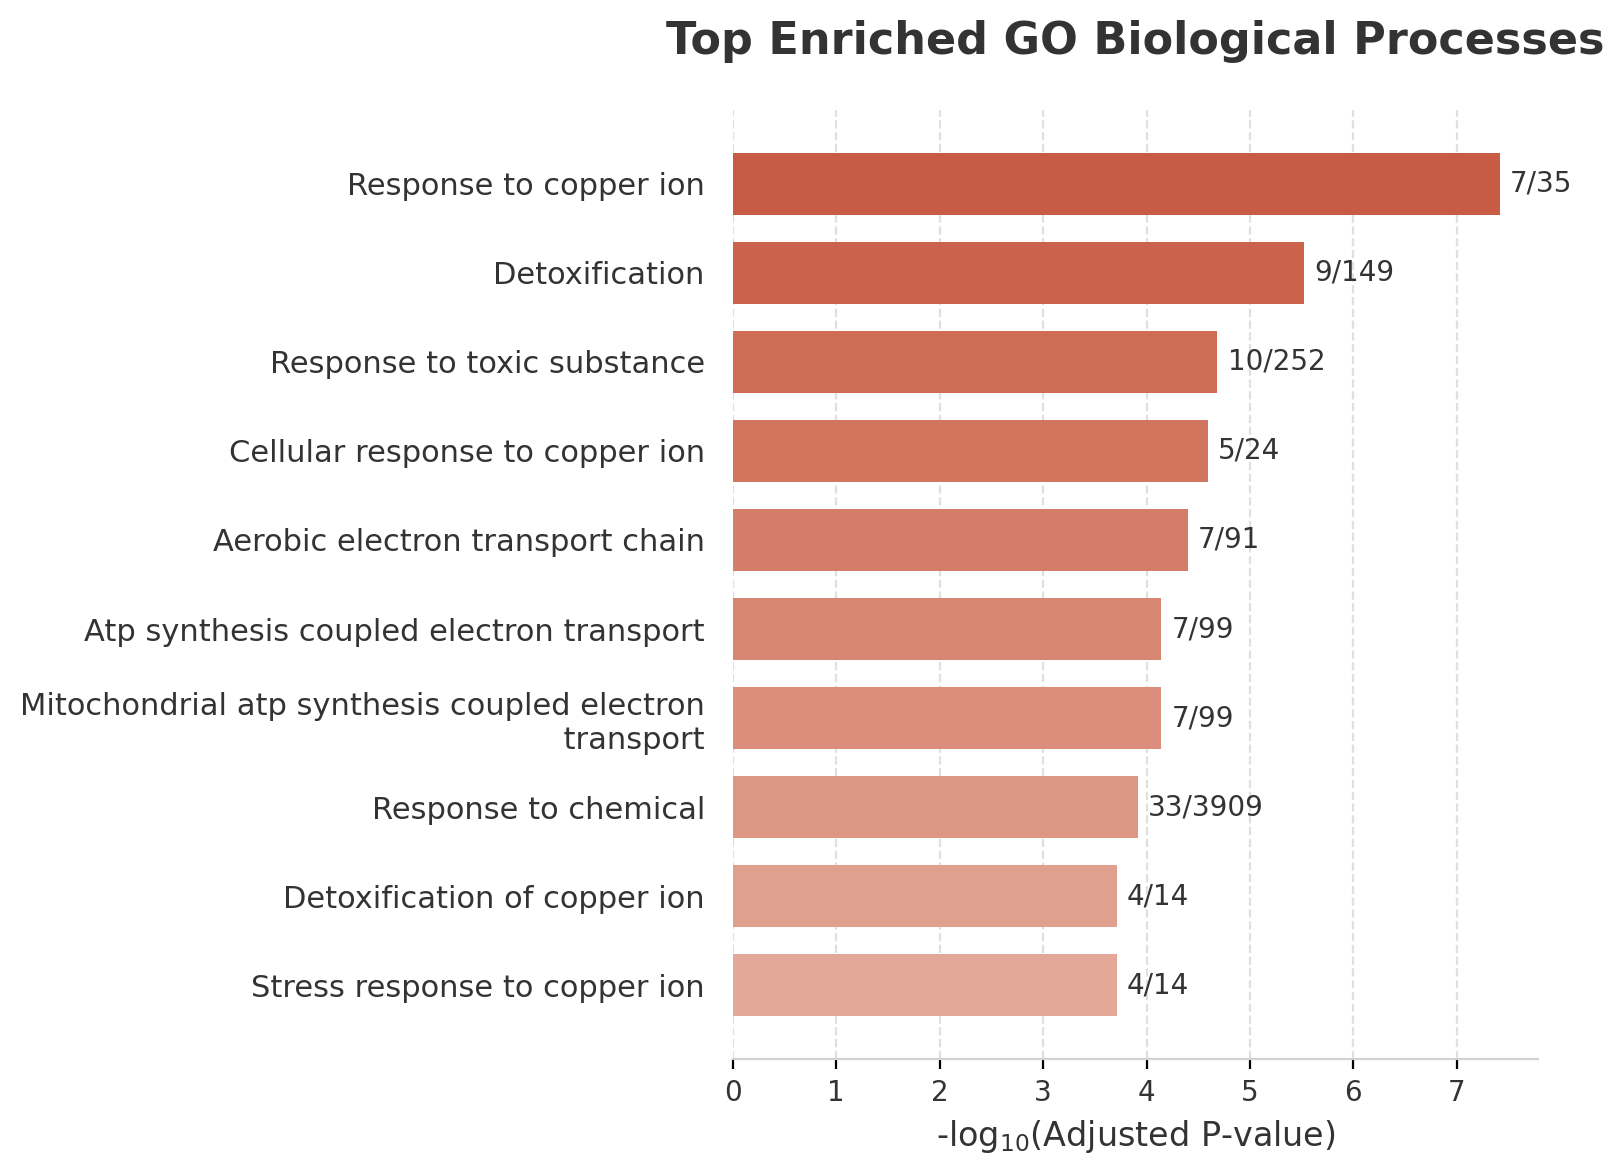

In [10]:
# ==============================
# Import required packages
# ==============================
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# ==============================
# Set working directory
# ==============================
os.chdir("/root/Cycle/Github")
print("Current working directory:", os.getcwd())

# ==============================
# Add HarmoCycle module path
# ==============================
sys.path.append("./HarmoCycle/")

# Import custom functions
from HarmoCycle import *
from Utils import run_comprehensive_enrichment, display_enrichment_results, plot_go_bp_enrichment

# ==============================
# Prepare upregulated gene list
# ==============================
temp_res = upregulated_genes.names.tolist()

ORGANISM = 'Human'

# ==============================
# Load gProfiler results
# ==============================
df = pd.read_csv('./Dataset/Preprocessed_GBMap/gProfiler_Up_gene_GBMap.csv')

# Keep only GO Biological Process terms
df_bp = df[df['source'] == 'GO:BP'].copy()

# Construct Enrichr-like format
df_bp['Gene_set'] = 'GO_Biological_Process_gProfiler'
df_bp['Term'] = df_bp['term_name'] + " (" + df_bp['term_id'] + ")"
df_bp['Overlap'] = df_bp['intersection_size'].astype(str) + "/" + df_bp['term_size'].astype(str)
df_bp['P-value'] = df_bp['adjusted_p_value']  # gProfiler provides adjusted p-values
df_bp['Adjusted P-value'] = df_bp['adjusted_p_value']
df_bp['Genes'] = df_bp['intersections'].str.replace(",", ";")

# Select relevant columns
enrichr_like = df_bp[['Gene_set','Term','Overlap','P-value','Adjusted P-value','Genes']]

# ==============================
# Display and plot enrichment results
# ==============================
display_enrichment_results(enrichr_like, top_n=10)
plot_go_bp_enrichment(
    enrichr_like,
    top_n=10,
    save_path='./FigurePlot/GBMap_Analysis/GBMap_cluster2_upregulated_GO_BP_enrichment.png'
)

# Down gene GO

Current working directory: /root/Cycle/Github


                Enrichment Analysis Results

--- GO Biological Process (Top 10) ---
No significant enrichment results found for 'GO_Biological_Process_2021'.

--- GO Molecular Function (Top 10) ---
No significant enrichment results found for 'GO_Molecular_Function_2021'.

--- GO Cellular Component (Top 10) ---
No significant enrichment results found for 'GO_Cellular_Component_2021'.
--- Data Prepared for Plotting ---
                                 Term  -log10(AdjP)   Overlap
168          Mitotic nuclear division     55.345662    77/282
207                 Organelle fission     57.109417    98/500
267          Regulation of cell cycle     57.453527  137/1087
272  Regulation of cell cycle process     58.072742   115/720
205                  Nuclear division     60.366489    97/452
109            Chromosome segregation     69.978357   103/427
160                Mitotic cell cycle     80.827550   149/892
163        Mitotic cell cycle proce

/root/Cycle/Github/./HarmoCycle/Utils.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Term'] = plot_data['Term'].str.replace(r'\s\(GO:\d+\)$', '', regex=True)
/root/Cycle/Github/./HarmoCycle/Utils.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Term'] = plot_data['Term'].apply(


Plot saved to: ./FigurePlot/GBMap_Analysis/GBMap_cluster2_downregulated_GO_BP_enrichment.png
Tip: For Adobe Illustrator editing, save as .pdf or .svg format.


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Top Enriched GO Biological Processes'}, xlabel='-log$_{10}$(Adjusted P-value)'>)

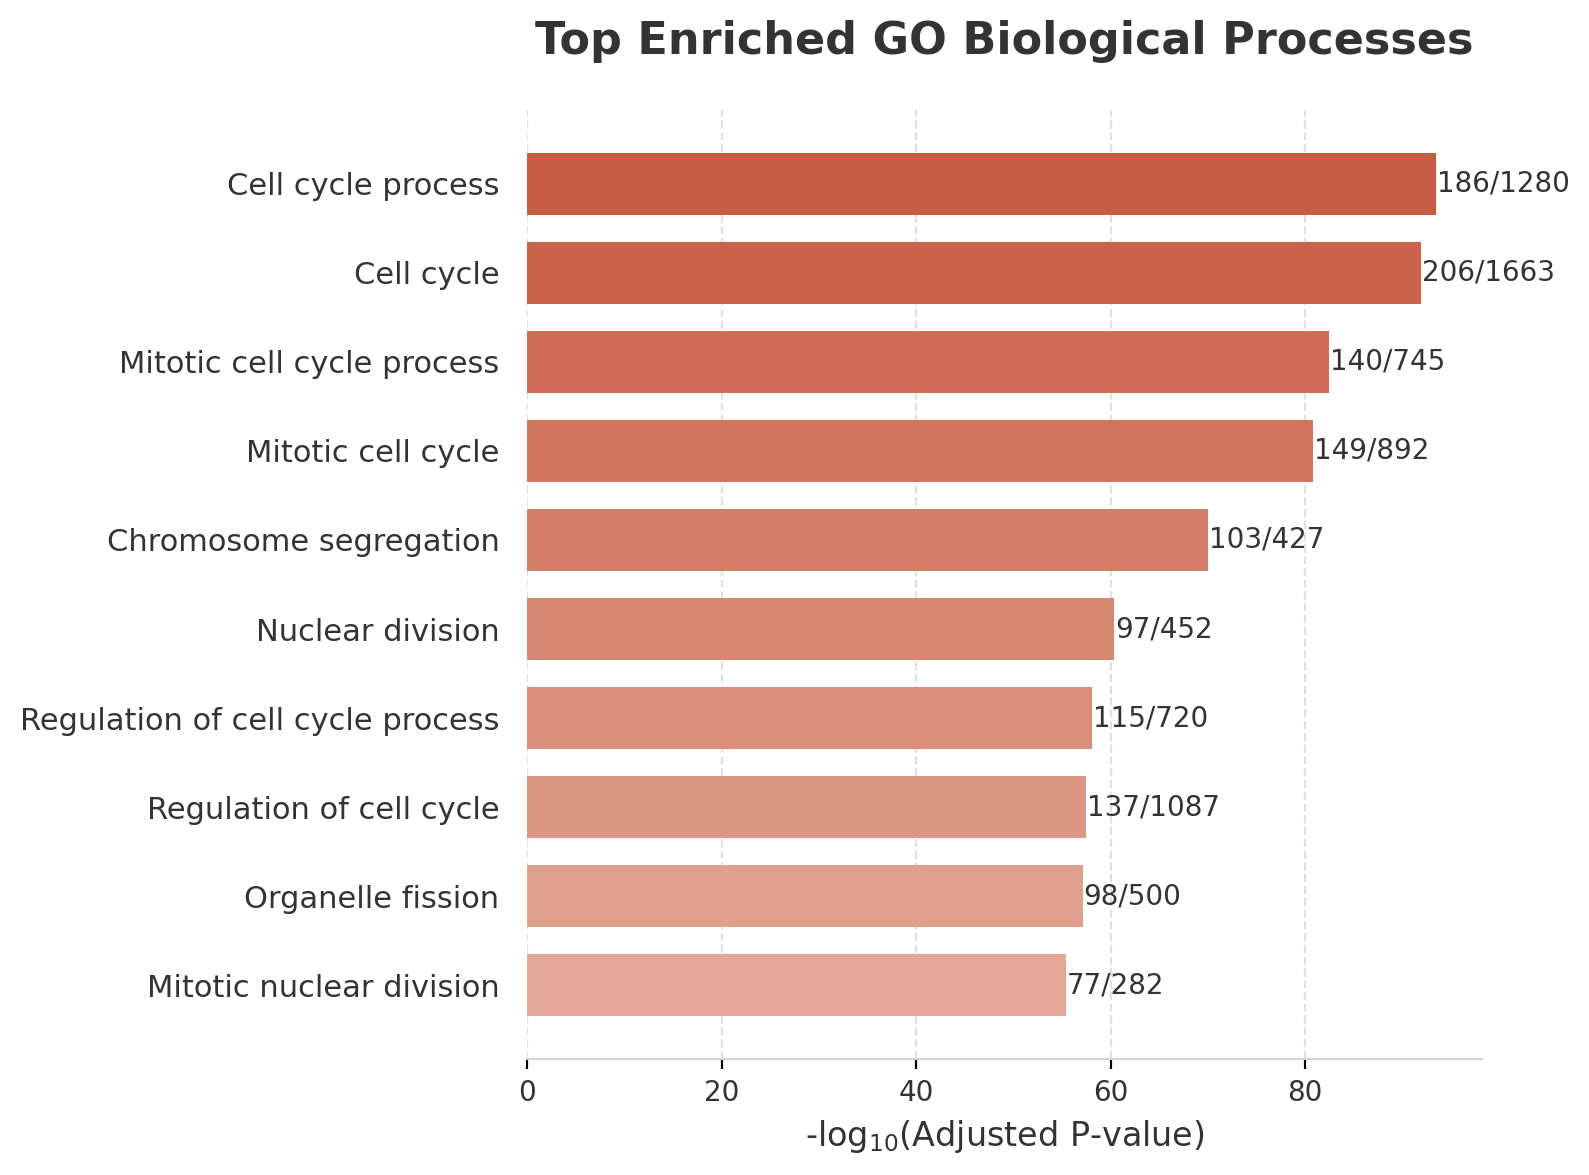

In [11]:
# ==============================
# Import required packages
# ==============================
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# ==============================
# Set working directory
# ==============================
os.chdir("/root/Cycle/Github")
print("Current working directory:", os.getcwd())

# ==============================
# Add HarmoCycle module path
# ==============================
sys.path.append("./HarmoCycle/")

# Import custom functions
from HarmoCycle import *
from Utils import run_comprehensive_enrichment, display_enrichment_results, plot_go_bp_enrichment

# ==============================
# Prepare upregulated gene list
# ==============================
temp_res = upregulated_genes.names.tolist()

ORGANISM = 'Human'

# ==============================
# Load gProfiler results
# ==============================
df = pd.read_csv('./Dataset/Preprocessed_GBMap/gProfiler_Down_gene_GBMap.csv')

# Keep only GO Biological Process terms
df_bp = df[df['source'] == 'GO:BP'].copy()

# Construct Enrichr-like format
df_bp['Gene_set'] = 'GO_Biological_Process_gProfiler'
df_bp['Term'] = df_bp['term_name'] + " (" + df_bp['term_id'] + ")"
df_bp['Overlap'] = df_bp['intersection_size'].astype(str) + "/" + df_bp['term_size'].astype(str)
df_bp['P-value'] = df_bp['adjusted_p_value']  # gProfiler provides adjusted p-values
df_bp['Adjusted P-value'] = df_bp['adjusted_p_value']
df_bp['Genes'] = df_bp['intersections'].str.replace(",", ";")

# Select relevant columns
enrichr_like = df_bp[['Gene_set','Term','Overlap','P-value','Adjusted P-value','Genes']]

# ==============================
# Display and plot enrichment results
# ==============================
display_enrichment_results(enrichr_like, top_n=10)
plot_go_bp_enrichment(
    enrichr_like,
    top_n=10,
    save_path='./FigurePlot/GBMap_Analysis/GBMap_cluster2_downregulated_GO_BP_enrichment.png'
)

# DFA DEG Analysis between Target vs Others

In [12]:
# ==============================
# Import required packages
# ==============================
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# ==============================
# Set working directory
# ==============================
os.chdir("/root/Cycle/Github")
print("Current working directory:", os.getcwd())

# ==============================
# Add HarmoCycle module path
# ==============================
sys.path.append("./HarmoCycle/")

# Import custom functions
from HarmoCycle import *
from Utils import calculate_gene_oscillation_properties_v2

# Since `adata` has already been ordered using `pca_adjust_angle`,
# we can directly run frequency-domain feature calculation.
adata = calculate_gene_oscillation_properties_v2(adata)

# Extract gene-level metadata
temp_df = adata.var

# Keep only genes with dominant amplitude > 0.3
adata = adata[:, temp_df[temp_df.dominant_amplitude > 0.3].index].copy()

# Create a working copy of the filtered AnnData object
adata_sub = adata.copy()

# ==============================
# Inspect clustering information
# ==============================
print("Original values of kmeans_cluster:", adata_sub.obs['kmeans_cluster'].unique())
print("Data type of kmeans_cluster:", type(adata_sub.obs['kmeans_cluster'].iloc[0]))

# Convert kmeans_cluster to categorical type for proper handling
adata_sub.obs['kmeans_cluster'] = adata_sub.obs['kmeans_cluster'].astype(str).astype('category')
print("Converted data type:", adata_sub.obs['kmeans_cluster'].dtype)
print("Cluster categories:", adata_sub.obs['kmeans_cluster'].cat.categories.tolist())

# ==============================
# Re-import packages for analysis and plotting
# ==============================
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Set Scanpy verbosity and print header
sc.settings.verbosity = 3
sc.logging.print_header()

# ==============================
# Define comparison groups for differential expression
# ==============================
adata_sub.obs['comparison_group'] = 'other'

# Assign "reference" to all clusters except cluster '2'
adata_sub.obs.loc[~adata_sub.obs['kmeans_cluster'].isin(['2']), 'comparison_group'] = 'reference'

# Assign "target" to cluster '2'
adata_sub.obs.loc[adata_sub.obs['kmeans_cluster'].isin(['2']), 'comparison_group'] = 'target'

# Convert to categorical type
adata_sub.obs['comparison_group'] = adata_sub.obs['comparison_group'].astype('category')

print("New group distribution:")
print(adata_sub.obs['comparison_group'].value_counts())

# ==============================
# Perform differential gene expression analysis
# ==============================
sc.tl.rank_genes_groups(
    adata_sub, 
    groupby='comparison_group',
    groups=['target'],       # Compare target group (cluster 2)
    reference='reference',   # Against reference group (all other clusters)
    method='wilcoxon',       # Use Wilcoxon rank-sum test
    corr_method='benjamini-hochberg',  # Multiple testing correction
    use_raw=False
)

print("Differential expression analysis completed!")

# ==============================
# Extract results
# ==============================
result = sc.get.rank_genes_groups_df(adata_sub, group='target')

# Restrict AnnData object to genes in the result
adata_sub = adata_sub[:, result.names]

# Add dominant amplitude values to the result table
result['amp'] = adata_sub.var['dominant_amplitude'].values

# ==============================
# Identify significantly upregulated and downregulated genes
# ==============================
upregulated_genes = result[
    (result['pvals_adj'] < 1e-10) & 
    (result['logfoldchanges'] > 1)
].sort_values('logfoldchanges', ascending=False)

downregulated_genes = result[
    (result['pvals_adj'] < 1e-10) & 
    (result['logfoldchanges'] < -1)
].sort_values('logfoldchanges', ascending=False)

print(f"\nFound {len(upregulated_genes)} significantly upregulated genes")
print(f"\nFound {len(downregulated_genes)} significantly downregulated genes")

# ==============================
# Handle zero p-values (replace with very small value for numerical stability)
# ==============================
result.loc[result['pvals_adj'] == 0, 'pvals_adj'] = 1e-299
result.loc[result['pvals'] == 0, 'pvals'] = 1e-299

upregulated_genes.loc[upregulated_genes['pvals_adj'] == 0, 'pvals_adj'] = 1e-299
upregulated_genes.loc[upregulated_genes['pvals'] == 0, 'pvals'] = 1e-299

downregulated_genes.loc[downregulated_genes['pvals'] == 0, 'pvals'] = 1e-299
downregulated_genes.loc[downregulated_genes['pvals_adj'] == 0, 'pvals_adj'] = 1e-299

# ==============================
# Sort genes by oscillation amplitude
# ==============================
upregulated_genes = upregulated_genes.sort_values('amp', ascending=False)
downregulated_genes = downregulated_genes.sort_values('amp', ascending=True)


Current working directory: /root/Cycle/Github
Original values of kmeans_cluster: ['2', '4', '0', '3', '1']
Categories (5, object): ['0', '1', '2', '3', '4']
Data type of kmeans_cluster: <class 'str'>
Converted data type: category
Cluster categories: ['0', '1', '2', '3', '4']
scanpy==1.9.8 anndata==0.9.2 umap==0.5.6 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13
New group distribution:
reference    25765
target       13084
Name: comparison_group, dtype: int64
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
Differential expression analysis completed!

Found 10 significantly 

# DFA Gene Volcano Plot

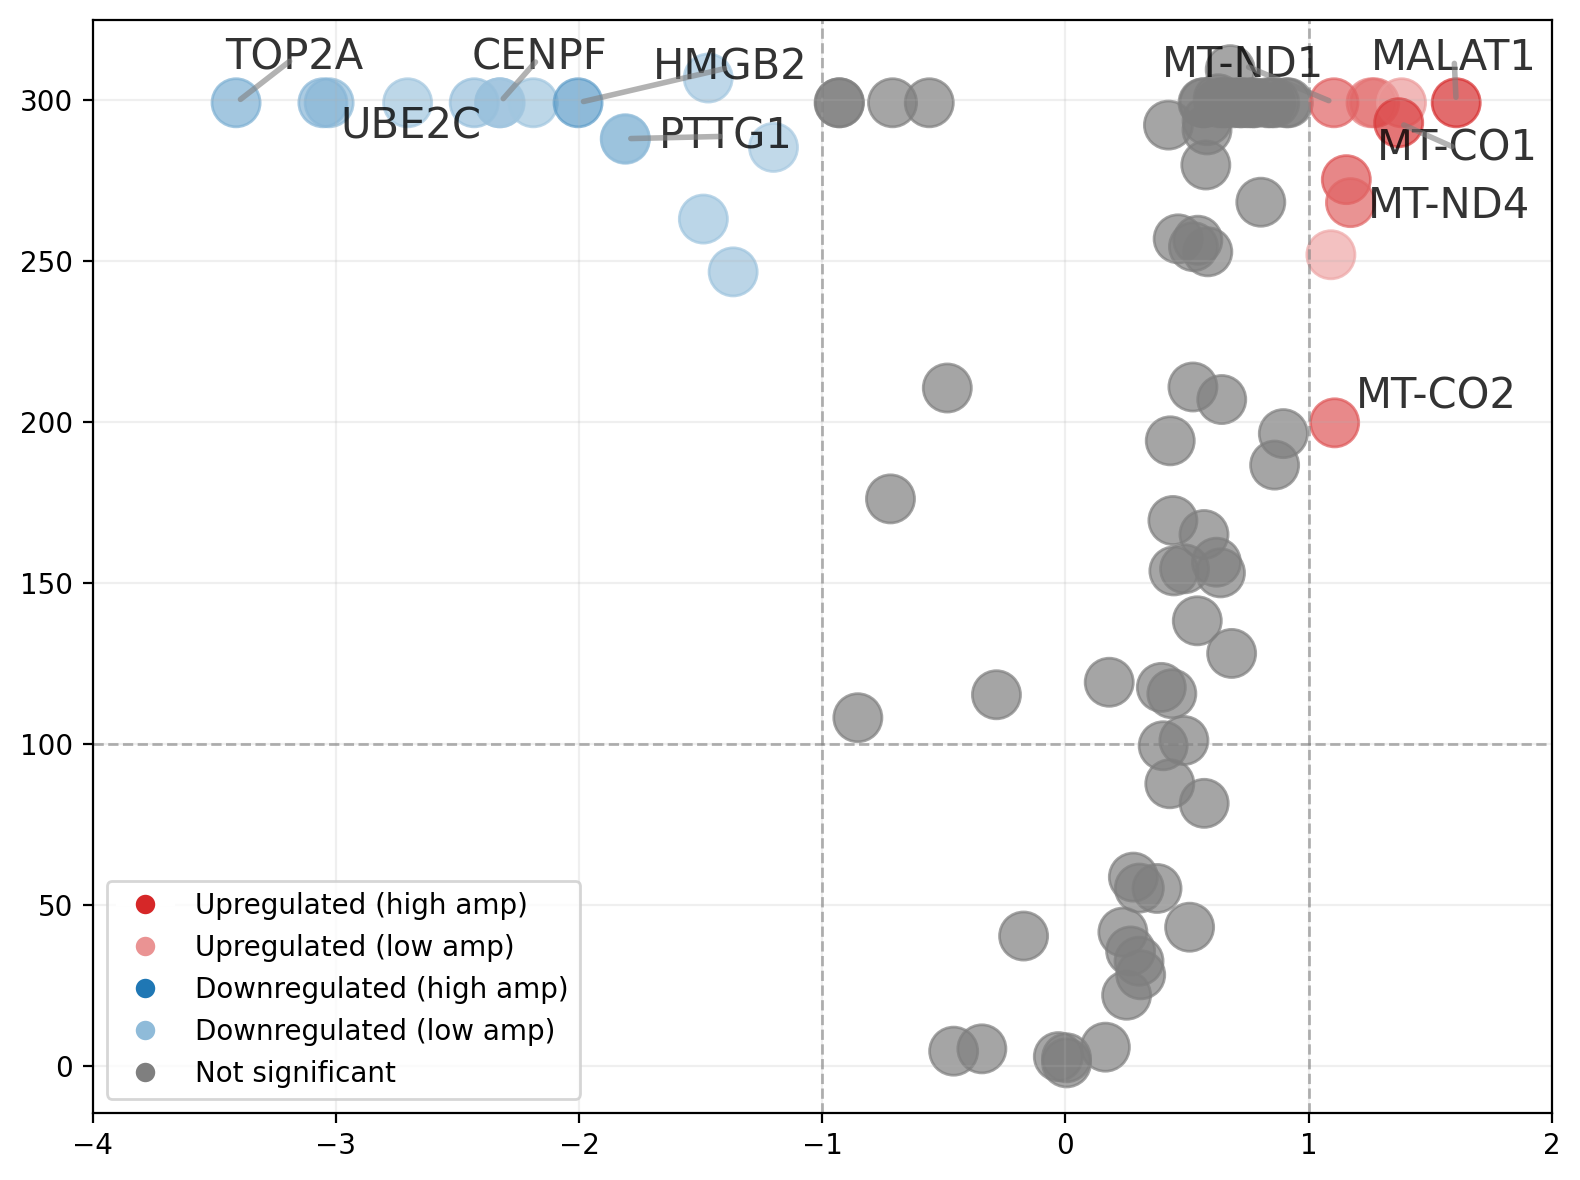

In [13]:
# ============================================
# Helper function: adjust color intensity
# ============================================
def adjust_color_intensity(hex_color, intensity):
    """
    Adjust the brightness of a given hex color based on intensity.
    intensity: float between 0 and 1
        - 1 = original color
        - 0 = lightest (close to white)
    """
    # Convert hex color to RGB
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    
    # Linear interpolation toward white
    r = int(255 - (255 - r) * intensity)
    g = int(255 - (255 - g) * intensity)
    b = int(255 - (255 - b) * intensity)
    
    # Ensure values are within valid range
    r = max(0, min(255, r))
    g = max(0, min(255, g))
    b = max(0, min(255, b))
    
    return f'#{r:02x}{g:02x}{b:02x}'


# ============================================
# Handle zero p-values (replace with tiny value)
# ============================================
result.loc[result['pvals_adj'] == 0, 'pvals_adj'] = 1e-299
result.loc[result['pvals'] == 0, 'pvals'] = 1e-299
upregulated_genes.loc[upregulated_genes['pvals_adj'] == 0, 'pvals_adj'] = 1e-299
upregulated_genes.loc[upregulated_genes['pvals'] == 0, 'pvals'] = 1e-299
downregulated_genes.loc[downregulated_genes['pvals'] == 0, 'pvals'] = 1e-299
downregulated_genes.loc[downregulated_genes['pvals_adj'] == 0, 'pvals_adj'] = 1e-299


# ============================================
# Define base colors
# ============================================
base_red = '#d62728'    # Red for upregulated genes
base_blue = '#1f77b4'   # Blue for downregulated genes
gray_color = '#7f7f7f'  # Gray for non-significant genes


# ============================================
# Volcano plot
# ============================================
plt.figure(figsize=(8, 6))

log2fc = result['logfoldchanges']
log10_pval = -np.log10(result['pvals_adj'])

sig_threshold = 1e-100
fc_threshold = 1
plt.xlim(-4, 2)

# Assign colors based on thresholds and amplitude
colors = []
for i in range(len(result)):
    pval = result['pvals_adj'].iloc[i]
    fc = result['logfoldchanges'].iloc[i]
    amp = result['amp'].iloc[i]
    
    # Normalize amplitude to [0, 1]
    normalized_amp = (amp - 0.2) / (1 - 0.2)  # assume amp range is 0.2–1
    
    if pval < sig_threshold and fc > fc_threshold:
        # Upregulated genes: deeper red with higher amplitude
        color_intensity = 0.3 + 0.7 * normalized_amp
        colors.append(adjust_color_intensity(base_red, color_intensity))
    elif pval < sig_threshold and fc < -fc_threshold:
        # Downregulated genes: deeper blue with higher amplitude
        color_intensity = 0.3 + 0.7 * normalized_amp
        colors.append(adjust_color_intensity(base_blue, color_intensity))
    else:
        colors.append(gray_color)  # Not significant

plt.scatter(log2fc, log10_pval, c=colors, alpha=0.7, s=300)


# ============================================
# Threshold lines
# ============================================
plt.axhline(-np.log10(sig_threshold), color='grey', linestyle='--', alpha=0.6, linewidth=1)
plt.axvline(x=fc_threshold, color='grey', linestyle='--', alpha=0.6, linewidth=1)
plt.axvline(x=-fc_threshold, color='grey', linestyle='--', alpha=0.6, linewidth=1)


# ============================================
# Label top genes
# ============================================
top_up_genes = upregulated_genes.head(5)
top_down_genes = downregulated_genes.tail(5)
top_genes = pd.concat([top_up_genes, top_down_genes])

from adjustText import adjust_text
texts = []
for i, (idx, row) in enumerate(top_genes.iterrows()):
    texts.append(plt.text(
        row['logfoldchanges'], 
        -np.log10(row['pvals_adj']),
        row['names'],
        fontsize=15, 
        alpha=0.8
    ))

# Automatically adjust text positions to avoid overlap
adjust_text(texts, 
            arrowprops=dict(arrowstyle='-', color='gray', alpha=0.6, lw=2),
            expand_points=(1.2, 1.2),
            expand_text=(1.2, 1.2),
            force_text=(0.5, 0.5))


# ============================================
# Legend
# ============================================
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=adjust_color_intensity(base_red, 1.0), markersize=8, label='Upregulated (high amp)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=adjust_color_intensity(base_red, 0.5), markersize=8, label='Upregulated (low amp)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=adjust_color_intensity(base_blue, 1.0), markersize=8, label='Downregulated (high amp)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=adjust_color_intensity(base_blue, 0.5), markersize=8, label='Downregulated (low amp)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=gray_color, markersize=8, label='Not significant')
]
plt.legend(handles=legend_elements, loc='lower left')


# ============================================
# Final layout and saving
# ============================================
plt.grid(True, alpha=0.2)
plt.tight_layout()

# Ensure output directories exist
png_dir = './FigurePlot/GBMap_Analysis'
os.makedirs(png_dir, exist_ok=True)

# Save as PNG for quick viewing
plt.savefig(os.path.join(png_dir, 'GBMap_cluster2_vs_others_DFA_DEG_volcano_plot.png'), dpi=300, bbox_inches='tight')

plt.show()


In [14]:
upregulated_genes.to_csv('./Experiment/Temp_Result/cluster2_vs_others_upregulated_DFA_genes.csv', index=False)
downregulated_genes.to_csv('./Experiment/Temp_Result/cluster2_vs_others_downregulated_DFA_genes.csv', index=False)

---

**We will proceed with GO analysis. In our manuscript, GO enrichment was conducted using g:Profiler because mitochondrial genes were involved. Specifically, all 10 upregulated genes were submitted to g:GOSt, with the results provided in *./Dataset/Preprocessed_GBMap/gProfiler_Up_DFA_gene_GBMap.csv*. Likewise, 19 downregulated genes were analyzed, and the corresponding results are available in *./Dataset/Preprocessed_GBMap/gProfiler_Down_DFA_gene_GBMap.csv*.**

---

In [15]:
import pandas as pd

# Read the CSV file containing downregulated genes
df = pd.read_csv("./Experiment/Temp_Result/cluster2_vs_others_downregulated_DFA_genes.csv")

# Extract only the 'names' column
names = df["names"]

# Save the extracted names to a text file, one gene name per line
output_path = "./Experiment/Temp_Result/cluster2_vs_others_downregulated_DFA_gene_names_only.txt"
names.to_csv(output_path, index=False, header=False)

import pandas as pd

# Read the CSV file containing upregulated genes
df = pd.read_csv("./Experiment/Temp_Result/cluster2_vs_others_upregulated_DFA_genes.csv")

# Extract only the 'names' column
names = df["names"]

# Save the extracted names to a text file, one gene name per line
output_path = "./Experiment/Temp_Result/cluster2_vs_others_upregulated_DFA_gene_names_only.txt"
names.to_csv(output_path, index=False, header=False)


# DFA Up Gene GO

Current working directory: /root/Cycle/Github


                Enrichment Analysis Results

--- GO Biological Process (Top 10) ---
No significant enrichment results found for 'GO_Biological_Process_2021'.

--- GO Molecular Function (Top 10) ---
No significant enrichment results found for 'GO_Molecular_Function_2021'.

--- GO Cellular Component (Top 10) ---
No significant enrichment results found for 'GO_Cellular_Component_2021'.
--- Data Prepared for Plotting ---
                                                 Term  -log10(AdjP) Overlap
31  Energy derivation by oxidation of organic\n  c...      5.776394   6/345
30                               Cellular respiration      6.703023   6/242
29                                Aerobic respiration      7.216409   6/199
28                     Proton transmembrane transport      7.338105   6/190
27                          Oxidative phosphorylation      8.032725   6/146
26                           Electron transport chain      8.422831   6/126

/root/Cycle/Github/./HarmoCycle/Utils.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Term'] = plot_data['Term'].str.replace(r'\s\(GO:\d+\)$', '', regex=True)
/root/Cycle/Github/./HarmoCycle/Utils.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Term'] = plot_data['Term'].apply(


Plot saved to: ./FigurePlot/GBMap_Analysis/GBMap_cluster2_DFA_upregulated_GO_BP_enrichment.png
Tip: For Adobe Illustrator editing, save as .pdf or .svg format.


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Top Enriched GO Biological Processes'}, xlabel='-log$_{10}$(Adjusted P-value)'>)

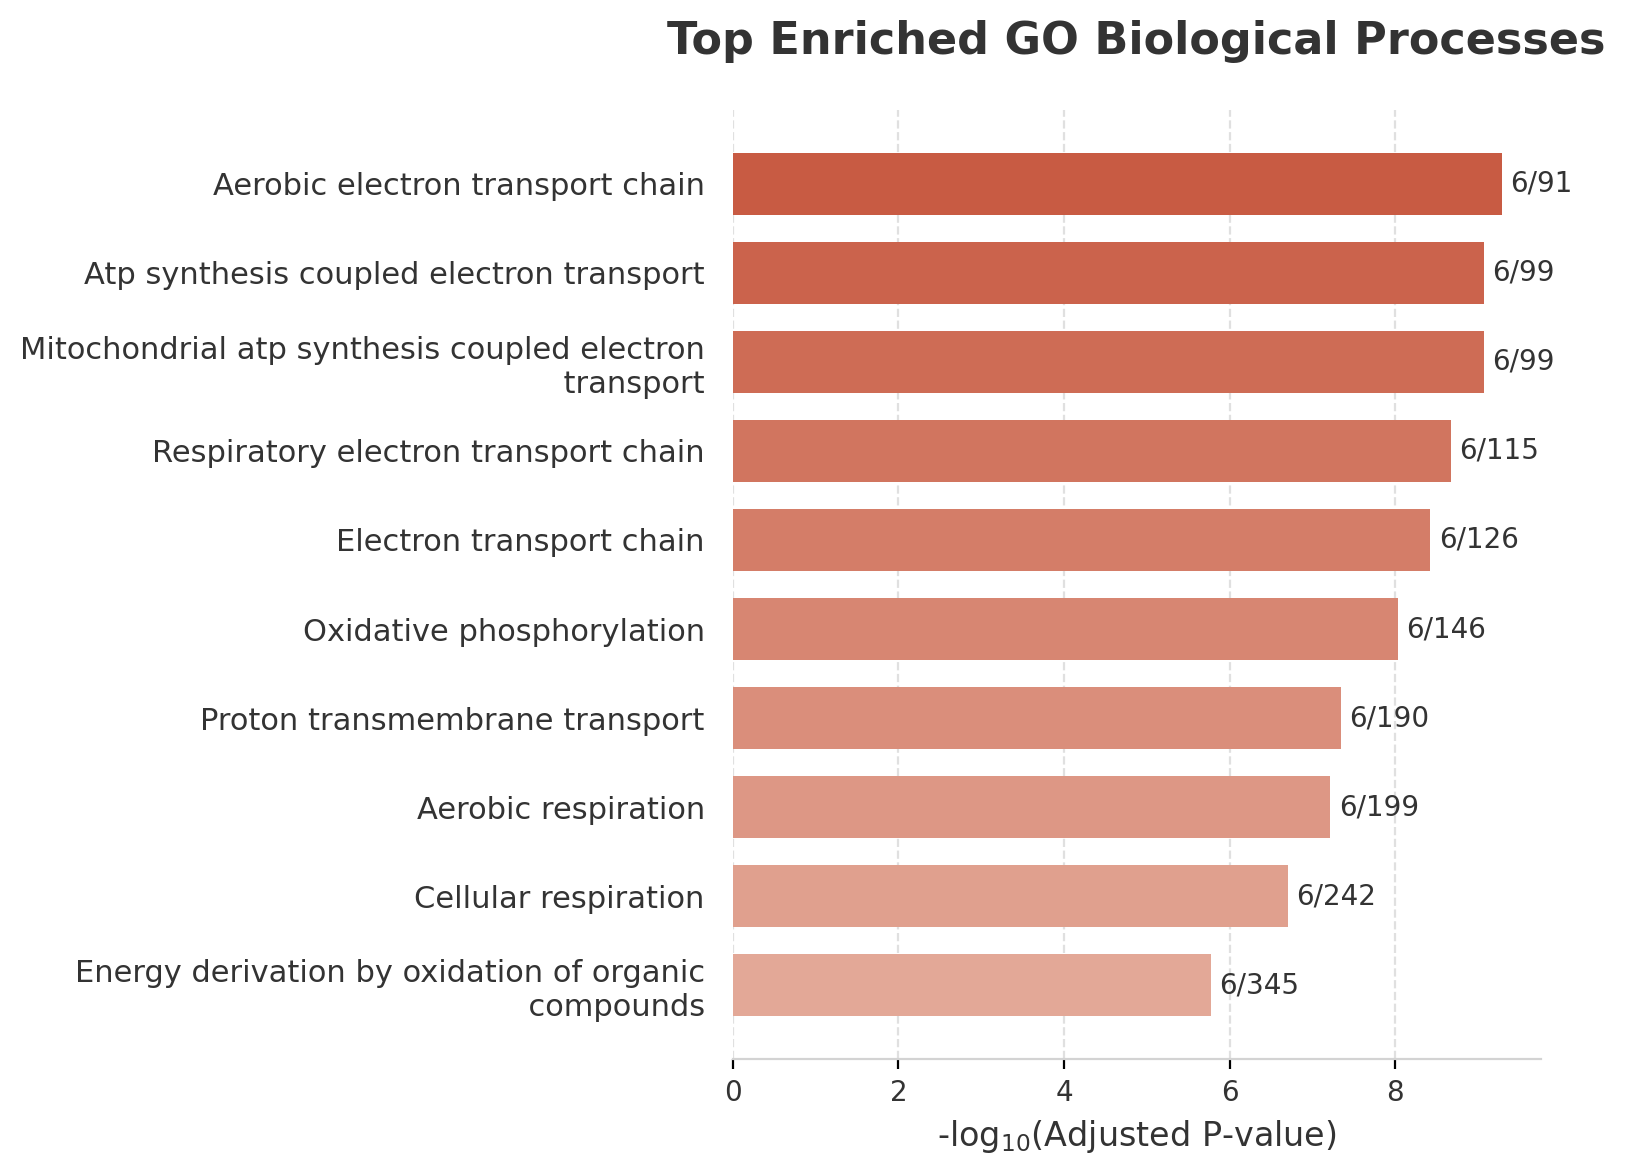

In [16]:
# ==============================
# Import required packages
# ==============================
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# ==============================
# Set working directory
# ==============================
os.chdir("/root/Cycle/Github")
print("Current working directory:", os.getcwd())

# ==============================
# Add HarmoCycle module path
# ==============================
sys.path.append("./HarmoCycle/")

# Import custom functions
from HarmoCycle import *
from Utils import run_comprehensive_enrichment, display_enrichment_results, plot_go_bp_enrichment

# ==============================
# Prepare upregulated gene list
# ==============================
temp_res = upregulated_genes.names.tolist()

ORGANISM = 'Human'

# ==============================
# Load gProfiler results
# ==============================
df = pd.read_csv('./Dataset/Preprocessed_GBMap/gProfiler_Up_DFA_gene_GBMap.csv')

# Keep only GO Biological Process terms
df_bp = df[df['source'] == 'GO:BP'].copy()

# Construct Enrichr-like format
df_bp['Gene_set'] = 'GO_Biological_Process_gProfiler'
df_bp['Term'] = df_bp['term_name'] + " (" + df_bp['term_id'] + ")"
df_bp['Overlap'] = df_bp['intersection_size'].astype(str) + "/" + df_bp['term_size'].astype(str)
df_bp['P-value'] = df_bp['adjusted_p_value']  # gProfiler provides adjusted p-values
df_bp['Adjusted P-value'] = df_bp['adjusted_p_value']
df_bp['Genes'] = df_bp['intersections'].str.replace(",", ";")

# Select relevant columns
enrichr_like = df_bp[['Gene_set','Term','Overlap','P-value','Adjusted P-value','Genes']]

# ==============================
# Display and plot enrichment results
# ==============================
display_enrichment_results(enrichr_like, top_n=10)
plot_go_bp_enrichment(
    enrichr_like,
    top_n=10,
    save_path='./FigurePlot/GBMap_Analysis/GBMap_cluster2_DFA_upregulated_GO_BP_enrichment.png'
)

# DFA Down Gene GO

Current working directory: /root/Cycle/Github


                Enrichment Analysis Results

--- GO Biological Process (Top 10) ---
No significant enrichment results found for 'GO_Biological_Process_2021'.

--- GO Molecular Function (Top 10) ---
No significant enrichment results found for 'GO_Molecular_Function_2021'.

--- GO Cellular Component (Top 10) ---
No significant enrichment results found for 'GO_Cellular_Component_2021'.
--- Data Prepared for Plotting ---
                                   Term  -log10(AdjP)  Overlap
12  Regulation of chromosome separation      5.642744     5/77
11                   Cell cycle process      5.684102  10/1280
10                           Cell cycle      5.997683  11/1663
9                Chromosome segregation      6.681705    8/427
8                         Cell division      6.807123    9/658
7          Sister chromatid segregation      6.807351    7/234
6        Nuclear chromosome segregation      7.647237    8/323
5                     Organ

/root/Cycle/Github/./HarmoCycle/Utils.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Term'] = plot_data['Term'].str.replace(r'\s\(GO:\d+\)$', '', regex=True)
/root/Cycle/Github/./HarmoCycle/Utils.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Term'] = plot_data['Term'].apply(


Plot saved to: ./FigurePlot/GBMap_Analysis/GBMap_cluster2_DFA_downregulated_GO_BP_enrichment.png
Tip: For Adobe Illustrator editing, save as .pdf or .svg format.


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Top Enriched GO Biological Processes'}, xlabel='-log$_{10}$(Adjusted P-value)'>)

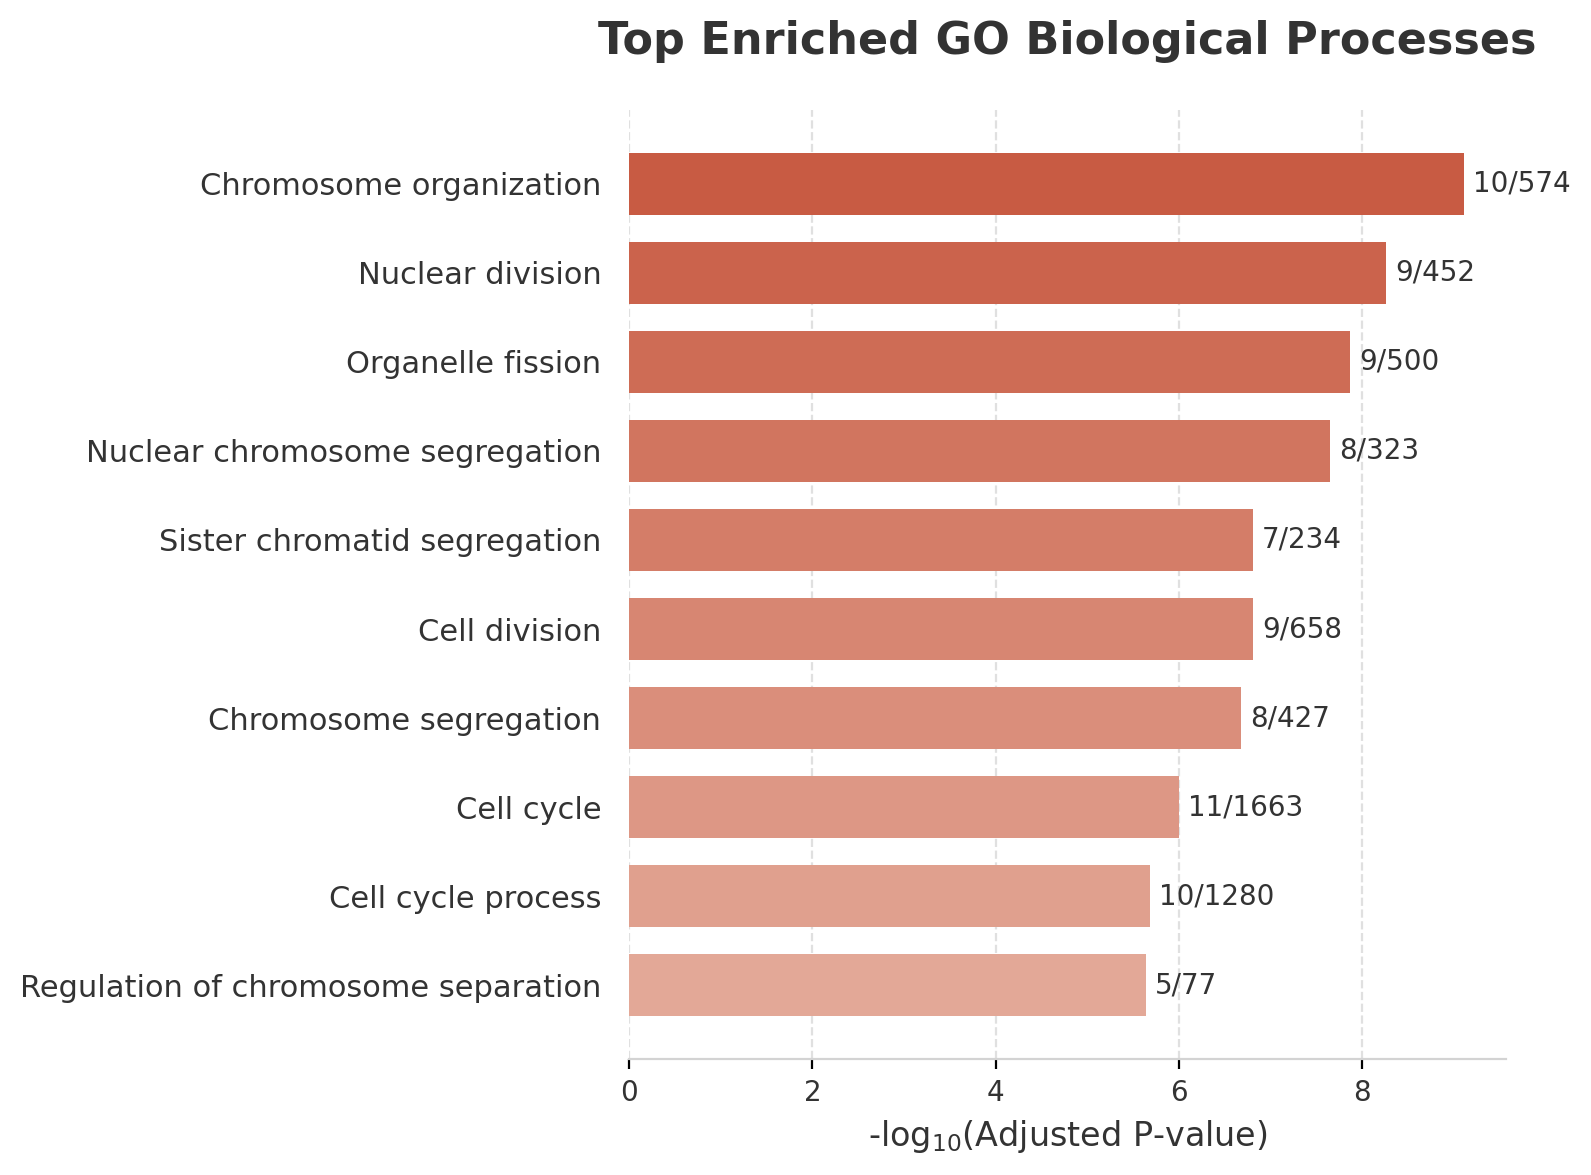

In [17]:
# ==============================
# Import required packages
# ==============================
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# ==============================
# Set working directory
# ==============================
os.chdir("/root/Cycle/Github")
print("Current working directory:", os.getcwd())

# ==============================
# Add HarmoCycle module path
# ==============================
sys.path.append("./HarmoCycle/")

# Import custom functions
from HarmoCycle import *
from Utils import run_comprehensive_enrichment, display_enrichment_results, plot_go_bp_enrichment

# ==============================
# Prepare upregulated gene list
# ==============================
temp_res = upregulated_genes.names.tolist()

ORGANISM = 'Human'

# ==============================
# Load gProfiler results
# ==============================
df = pd.read_csv('./Dataset/Preprocessed_GBMap/gProfiler_Down_DFA_gene_GBMap.csv')

# Keep only GO Biological Process terms
df_bp = df[df['source'] == 'GO:BP'].copy()

# Construct Enrichr-like format
df_bp['Gene_set'] = 'GO_Biological_Process_gProfiler'
df_bp['Term'] = df_bp['term_name'] + " (" + df_bp['term_id'] + ")"
df_bp['Overlap'] = df_bp['intersection_size'].astype(str) + "/" + df_bp['term_size'].astype(str)
df_bp['P-value'] = df_bp['adjusted_p_value']  # gProfiler provides adjusted p-values
df_bp['Adjusted P-value'] = df_bp['adjusted_p_value']
df_bp['Genes'] = df_bp['intersections'].str.replace(",", ";")

# Select relevant columns
enrichr_like = df_bp[['Gene_set','Term','Overlap','P-value','Adjusted P-value','Genes']]

# ==============================
# Display and plot enrichment results
# ==============================
display_enrichment_results(enrichr_like, top_n=10)
plot_go_bp_enrichment(
    enrichr_like,
    top_n=10,
    save_path='./FigurePlot/GBMap_Analysis/GBMap_cluster2_DFA_downregulated_GO_BP_enrichment.png'
)